In [1]:

pip install numpy==1.23.5 gensim==4.3.1

In [2]:

pip install scipy==1.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 288.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 27.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
^C


In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import pandas as pd
import numpy as np
import re

df = pd.read_csv("output.csv")

def clean_tokens(text):
    tokens = re.findall(r'\b[a-z]+\b', text.lower())
    return [t for t in tokens if t not in stop_words and len(t) > 1 and not t.isnumeric()]

corpus = df['title'].dropna().apply(clean_tokens).tolist()



In [25]:
from gensim.models import Word2Vec
from collections import Counter, defaultdict

model = Word2Vec(sentences=corpus, vector_size=50, window=3, min_count=1, seed=42)

word_counter = Counter(word for sentence in corpus for word in sentence)
top_n = 200
top_words = [w for w, _ in word_counter.most_common(top_n) if w in model.wv]
vectors = [model.wv[word] for word in top_words]

In [26]:
from collections import defaultdict
import numpy as np

word_to_volumes = defaultdict(list)

for tokens, volume in zip(corpus, df['volume_surge_price']):
    for word in tokens:
        if word in model.wv:
          if not np.isnan(volume):
            word_to_volumes[word].append(volume)


word_to_avg_volume = {
    word: np.mean(vols) for word, vols in word_to_volumes.items()
}

augmented_vectors = []
used_words = []
for word in top_words:
    if word in model.wv and word in word_to_avg_volume:
        vec = model.wv[word]
        vol = word_to_avg_volume[word]

        if np.any(np.isnan(vec)) or np.isnan(vol):
            print(f"NaN: {word}")
            continue

        full_vec = np.concatenate([vec, [vol]])
        augmented_vectors.append(full_vec)
        used_words.append(word)

vectors = augmented_vectors
top_words = used_words


In [27]:
import numpy as np
import random

def euclidean(a, b):
    return np.linalg.norm(a - b)

class KMeansScratch:
    def __init__(self, k, max_iters=100, seed=42):
        self.k = k
        self.max_iters = max_iters
        self.centroids = []
        self.labels = []
        random.seed(seed)

    def fit(self, X):
        self.centroids = random.sample(X, self.k)

        for _ in range(self.max_iters):
            clusters = [[] for _ in range(self.k)]

            for x in X:
                distances = [euclidean(x, c) for c in self.centroids]
                cluster_id = np.argmin(distances)
                clusters[cluster_id].append(x)

            new_centroids = []
            for cluster in clusters:
                if cluster:
                    new_centroids.append(np.mean(cluster, axis=0))
                else:
                    new_centroids.append(random.choice(X))  # empty cluster

            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids

        self.labels = []
        for x in X:
            distances = [euclidean(x, c) for c in self.centroids]
            self.labels.append(np.argmin(distances))

        return self

    def predict(self, X):
        return [
            np.argmin([euclidean(x, c) for c in self.centroids])
            for x in X
        ]


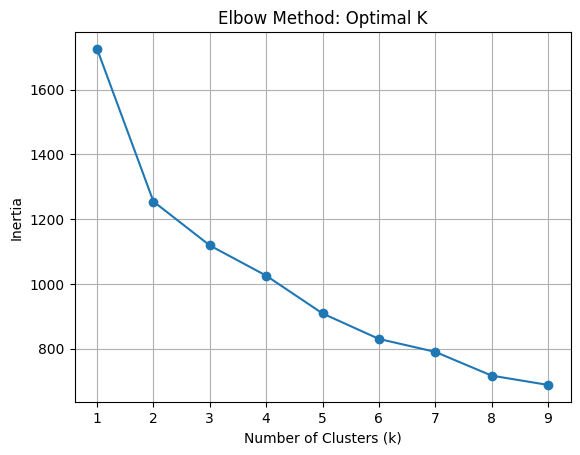

In [38]:
import matplotlib.pyplot as plt

inertias = []
X = vectors

for k in range(1, 10):
    km = KMeansScratch(k, seed=3).fit(X)
    inertia = sum(
        euclidean(x, km.centroids[km.labels[i]]) ** 2
        for i, x in enumerate(X)
    )
    inertias.append(inertia)

# Plot elbow curve
plt.plot(range(1, 10), inertias, marker='o')
plt.title('Elbow Method: Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


<ipython-input-50-d878717d0f77>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


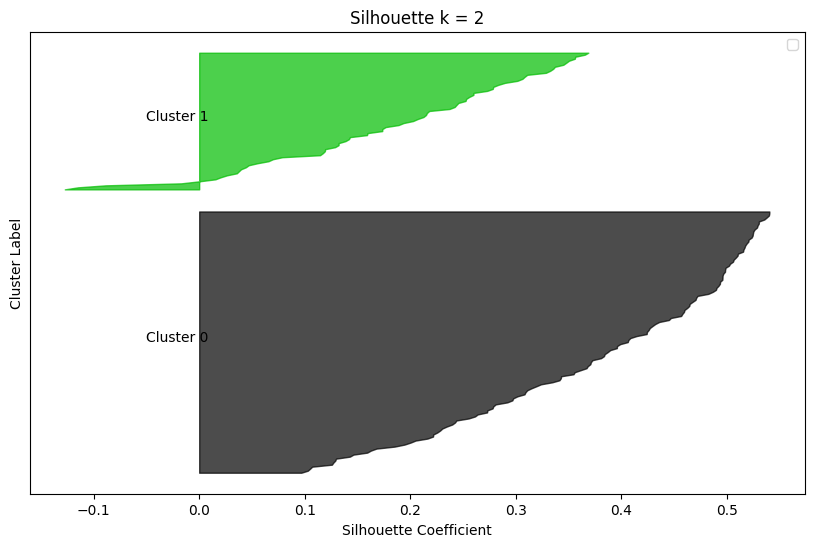

<ipython-input-50-d878717d0f77>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


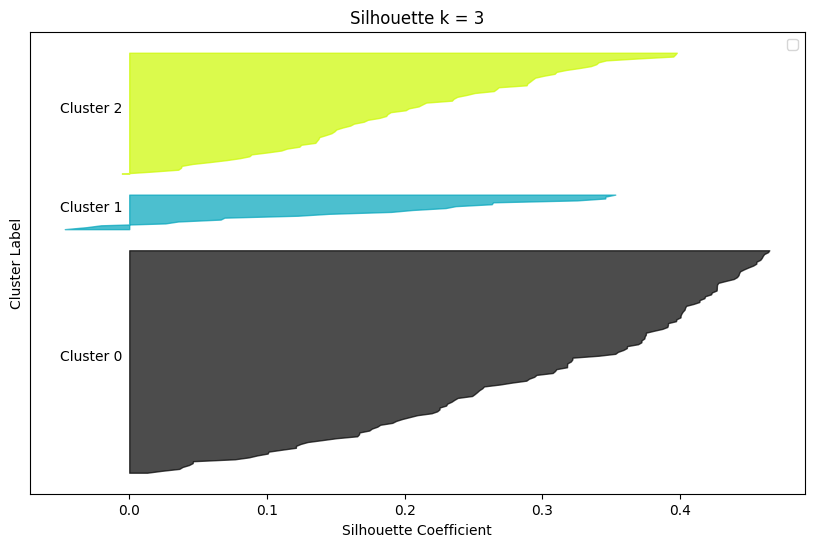

<ipython-input-50-d878717d0f77>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


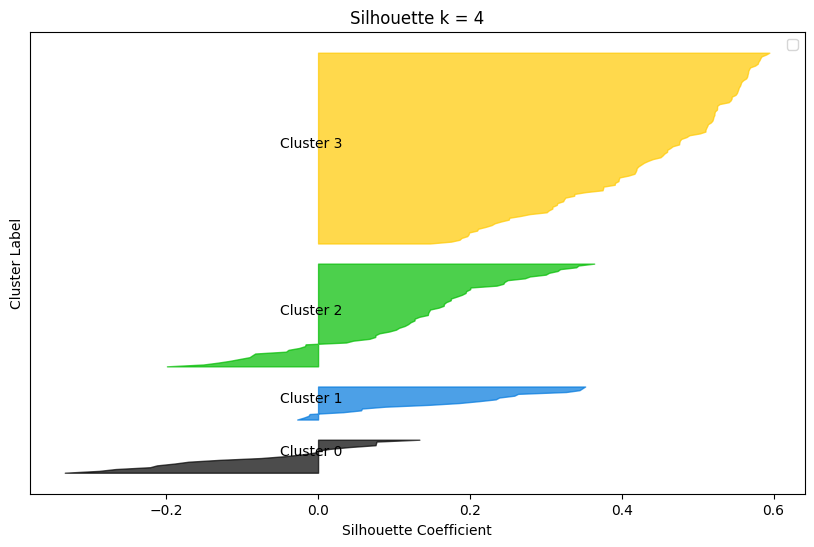

<ipython-input-50-d878717d0f77>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


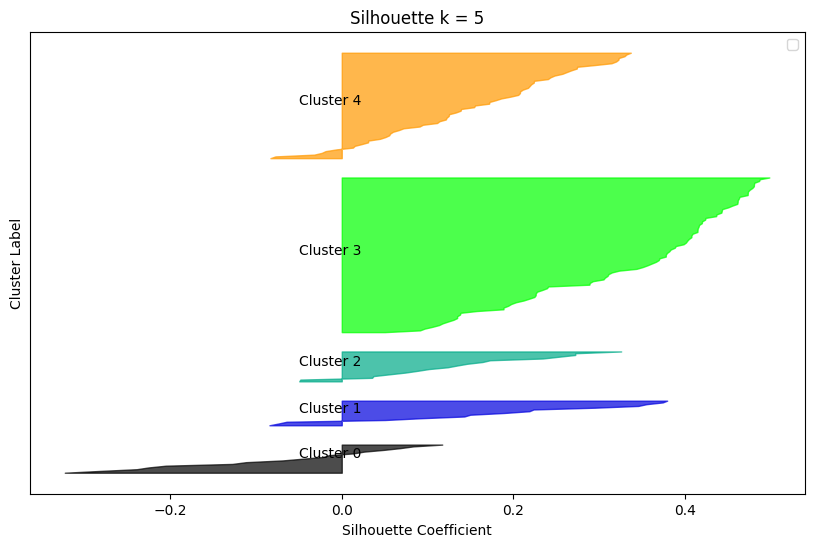

<ipython-input-50-d878717d0f77>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


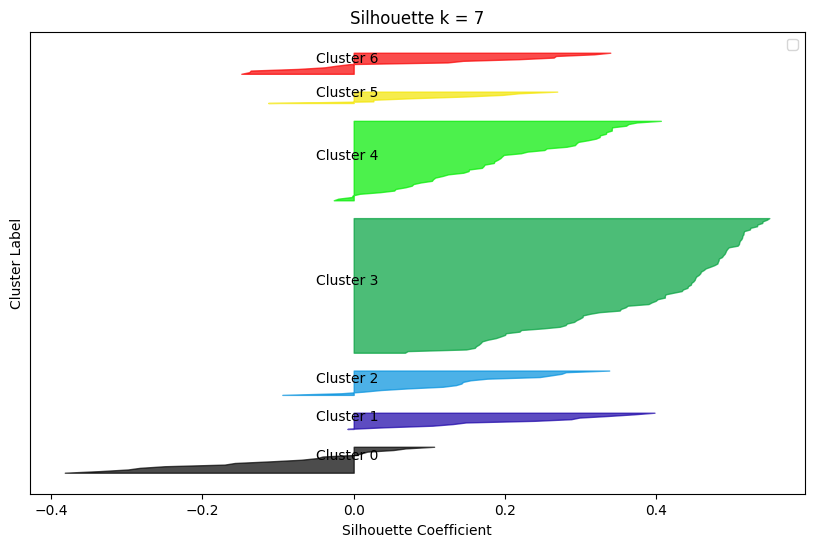

<ipython-input-50-d878717d0f77>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


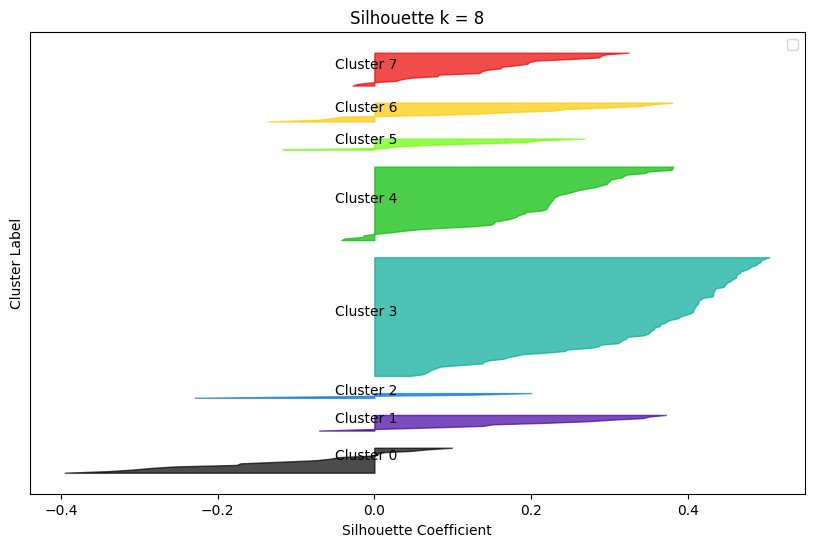

In [50]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

def plot_silhouette_scores(k):
    kmeans = KMeansScratch(k=k,seed=123).fit(X)
    labels = np.array(kmeans.labels)
    sample_silhouette_values = silhouette_samples(X, labels)
    avg_silhouette = np.mean(sample_silhouette_values)

    fig, ax = plt.subplots(figsize=(10, 6))
    y_lower = 10
    colors = cm.nipy_spectral(labels.astype(float) / k)

    for i in range(k):
        ith_cluster_silhouette = sample_silhouette_values[labels == i]
        ith_cluster_silhouette.sort()

        size_cluster = ith_cluster_silhouette.shape[0]
        y_upper = y_lower + size_cluster

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster, f"Cluster {i}")
        y_lower = y_upper + 10

    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    ax.set_title(f"Silhouette k = {k}")
    ax.set_yticks([])
    ax.legend()
    plt.show()

plot_silhouette_scores(2)
plot_silhouette_scores(3)
plot_silhouette_scores(4)
plot_silhouette_scores(5)
plot_silhouette_scores(7)
plot_silhouette_scores(8)



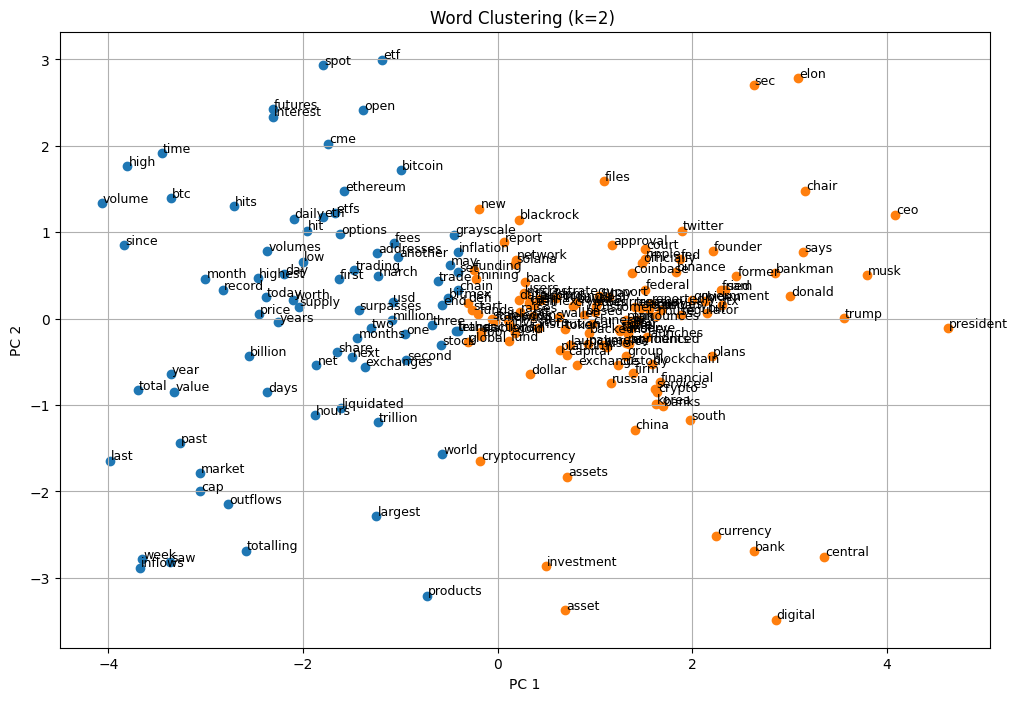

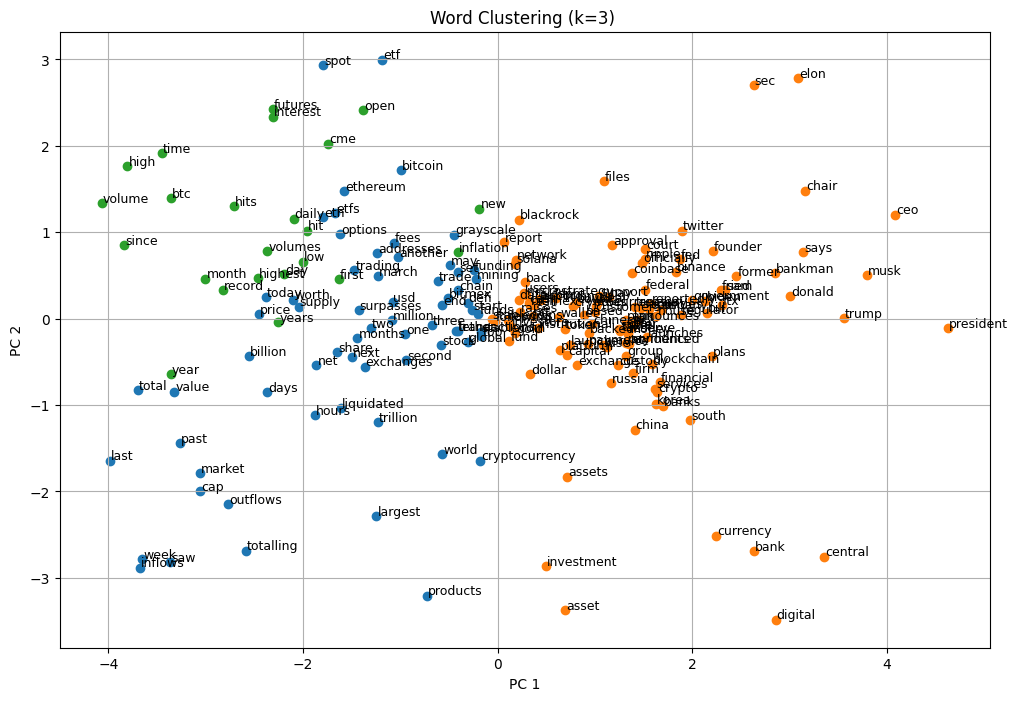

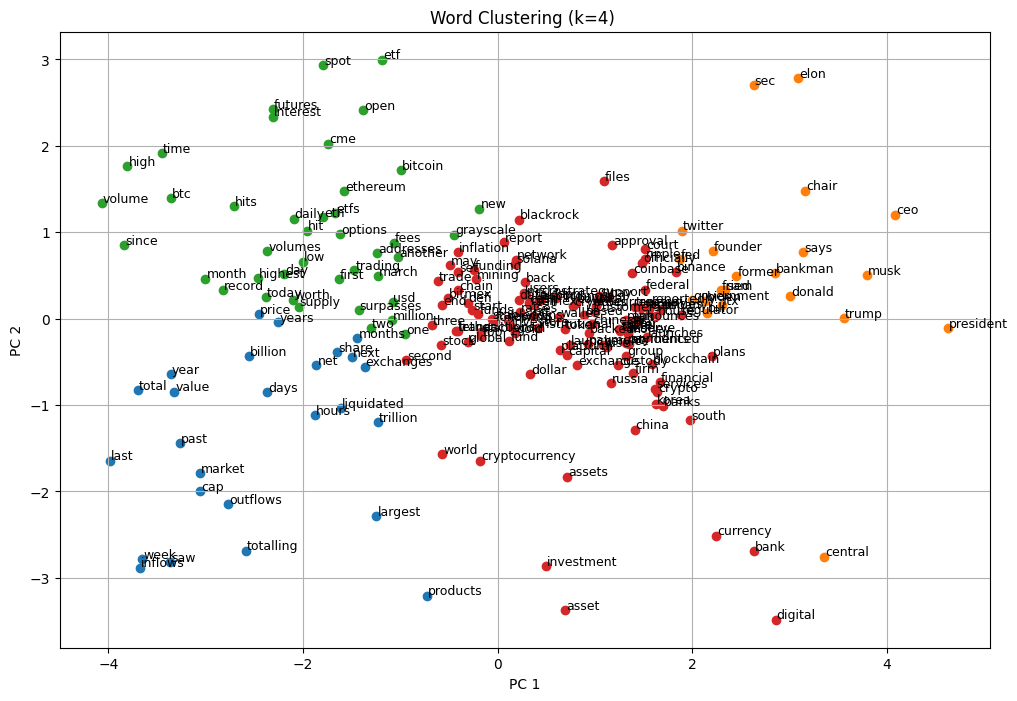

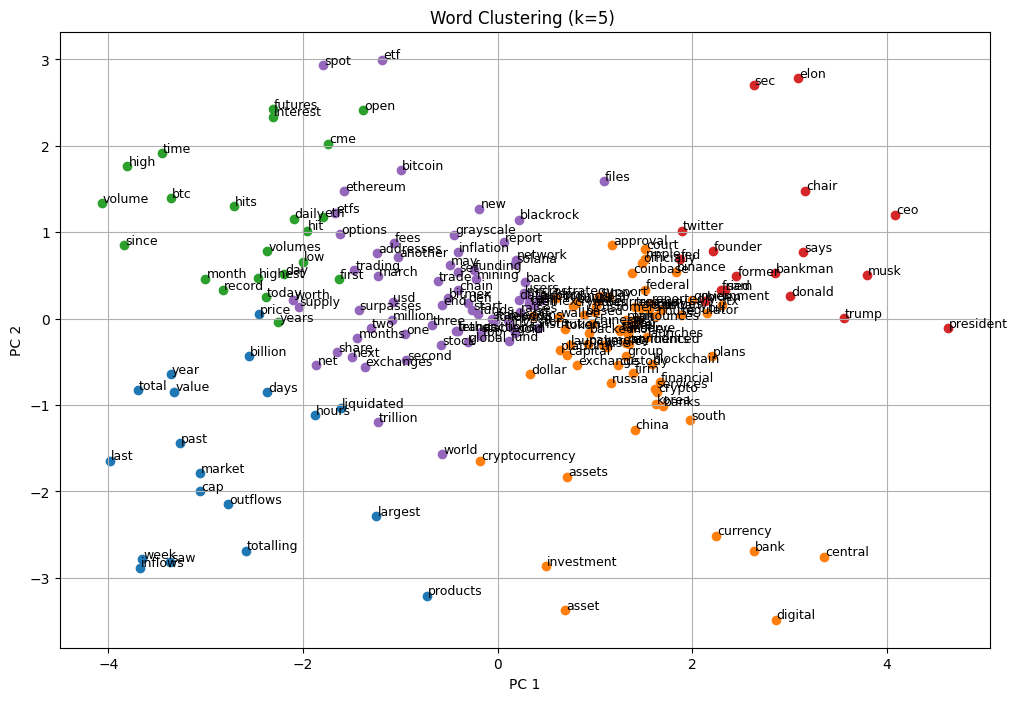

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

X = vectors
words = top_words

silhouette_scores = []
cluster_range = range(2, 10)
all_labels = []

for k in cluster_range:
    kmeans = KMeansScratch(k).fit(X)
    labels = kmeans.labels
    all_labels.append(labels)

    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# plt.figure(figsize=(10, 4))
# plt.plot(cluster_range, silhouette_scores, marker='o')
# plt.title('Silhouette Score for Different k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.grid(True)
# plt.show()

def plot_a(k):
    best_k = cluster_range[k]
    best_labels = all_labels[k]

    # Reduce dimensions for scatter plot
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # Plot scatter with word labels
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(best_labels)  # up to 10 clusters

    for i, word in enumerate(words):
        x, y = X_2d[i]
        plt.scatter(x, y, color=colors[i])
        plt.text(x + 0.01, y + 0.01, word, fontsize=9)

    plt.title(f'Word Clustering (k={best_k}) ')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.grid(True)
    plt.show()

plot_a(0)
plot_a(1)
plot_a(2)
plot_a(3)


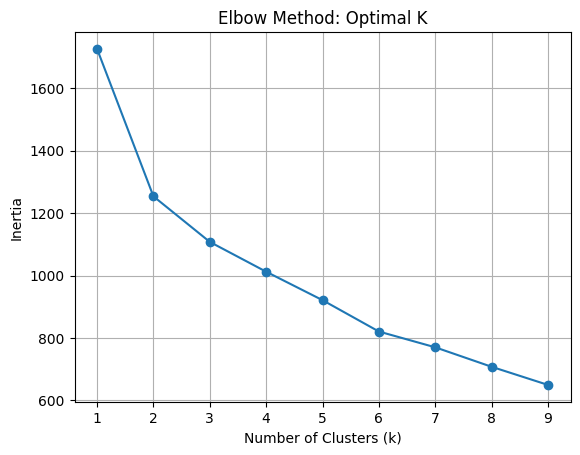

In [44]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
X = vectors  # make sure this is a clean NumPy array

for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=3, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)  # direct attribute from sklearn

# Plot elbow curve
plt.plot(range(1, 10), inertias, marker='o')
plt.title('Elbow Method: Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


<ipython-input-49-d633727197c7>:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


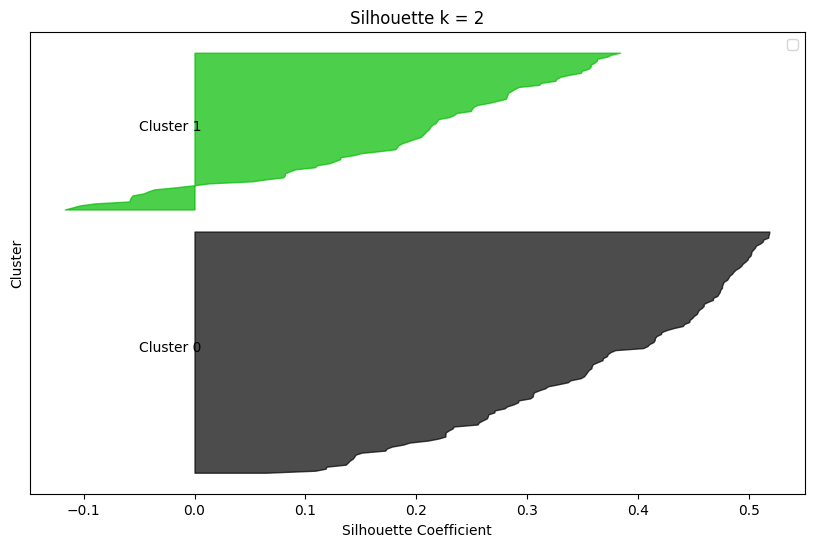

<ipython-input-49-d633727197c7>:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


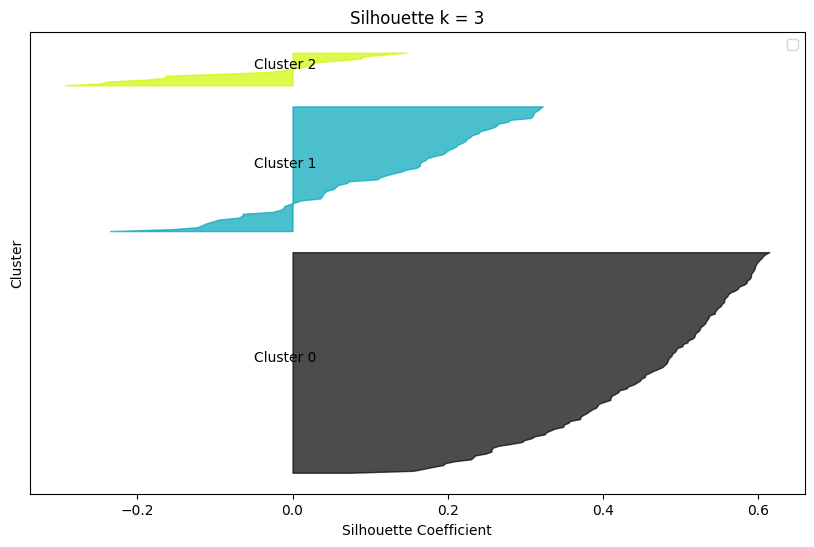

<ipython-input-49-d633727197c7>:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


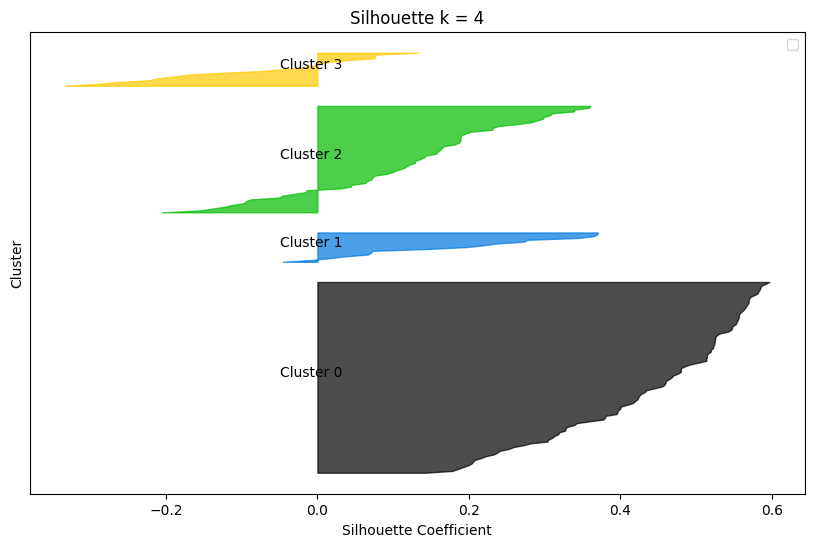

<ipython-input-49-d633727197c7>:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


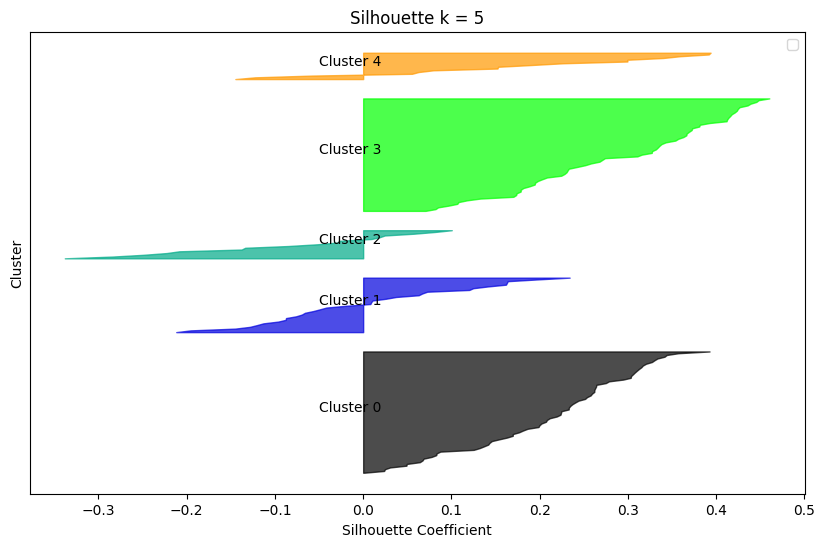

<ipython-input-49-d633727197c7>:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


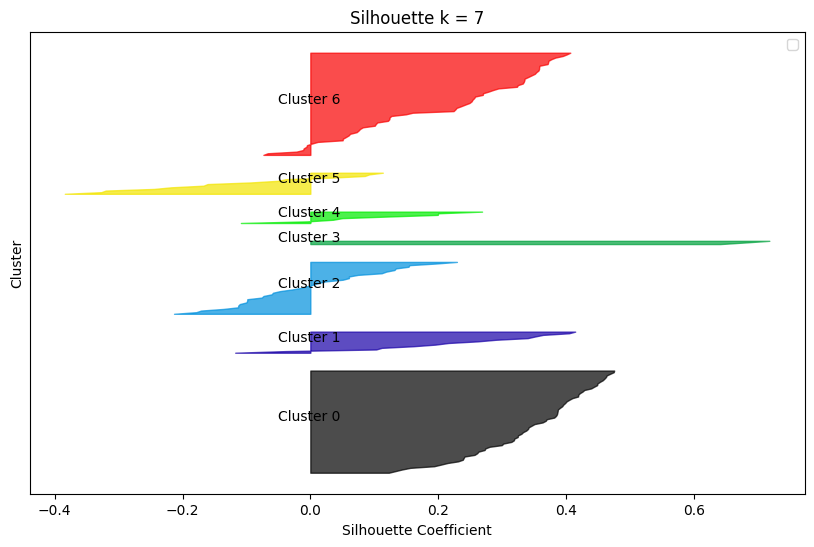

<ipython-input-49-d633727197c7>:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


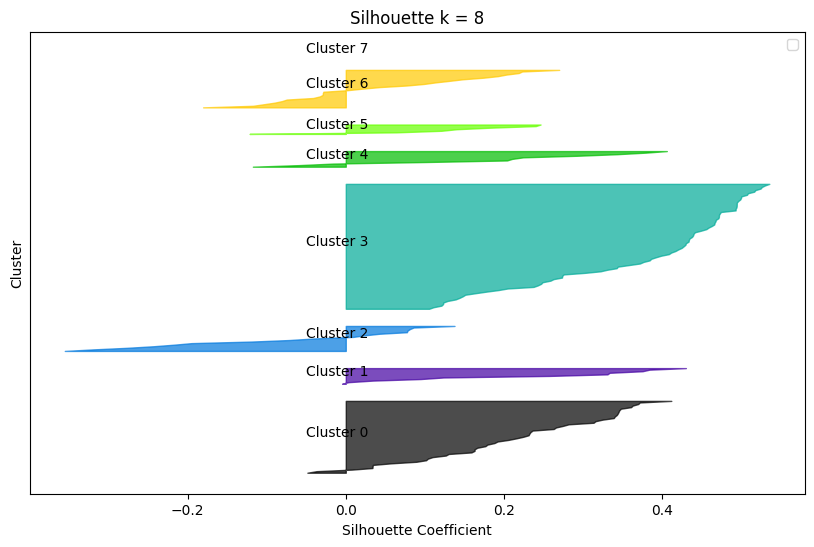

In [49]:
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

def plot_silhouette_scores(k):
    # Use scikit-learn KMeans
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=10).fit(X)
    labels = kmeans.labels_
    sample_silhouette_values = silhouette_samples(X, labels)
    avg_silhouette = np.mean(sample_silhouette_values)

    fig, ax = plt.subplots(figsize=(10, 6))
    y_lower = 10
    colors = cm.nipy_spectral(labels.astype(float) / k)

    for i in range(k):
        ith_cluster_silhouette = sample_silhouette_values[labels == i]
        ith_cluster_silhouette.sort()

        size_cluster = ith_cluster_silhouette.shape[0]
        y_upper = y_lower + size_cluster

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster, f"Cluster {i}")
        y_lower = y_upper + 10

    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster")
    ax.set_title(f"Silhouette k = {k}")
    ax.set_yticks([])
    ax.legend()
    plt.show()

# Example usage
for k in [2, 3, 4, 5, 7, 8]:
    plot_silhouette_scores(k)


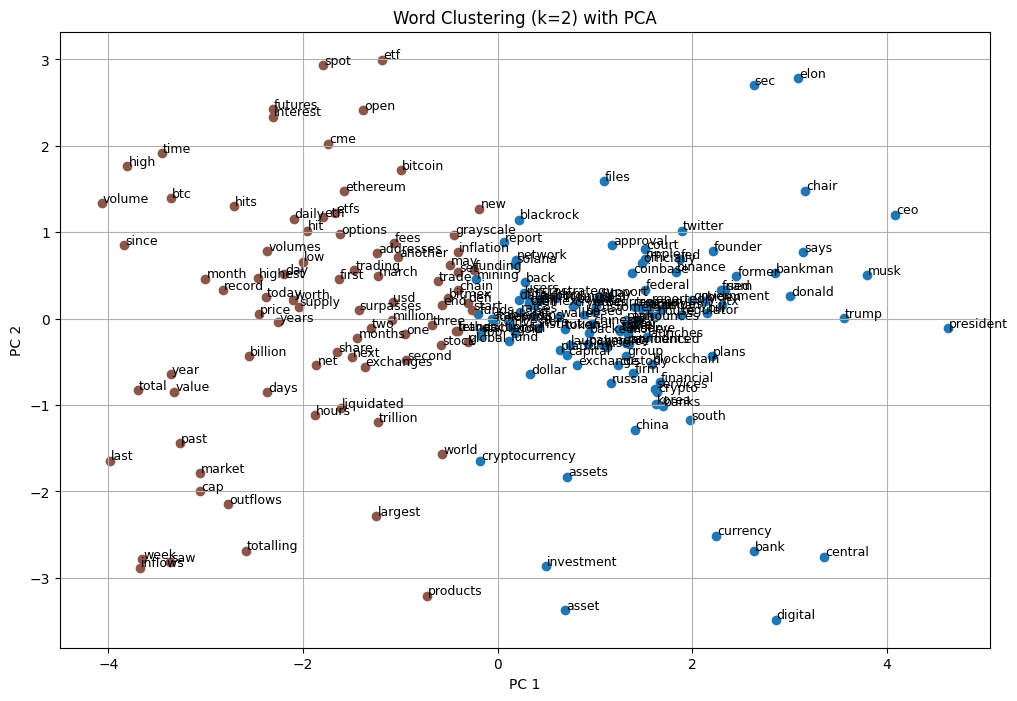

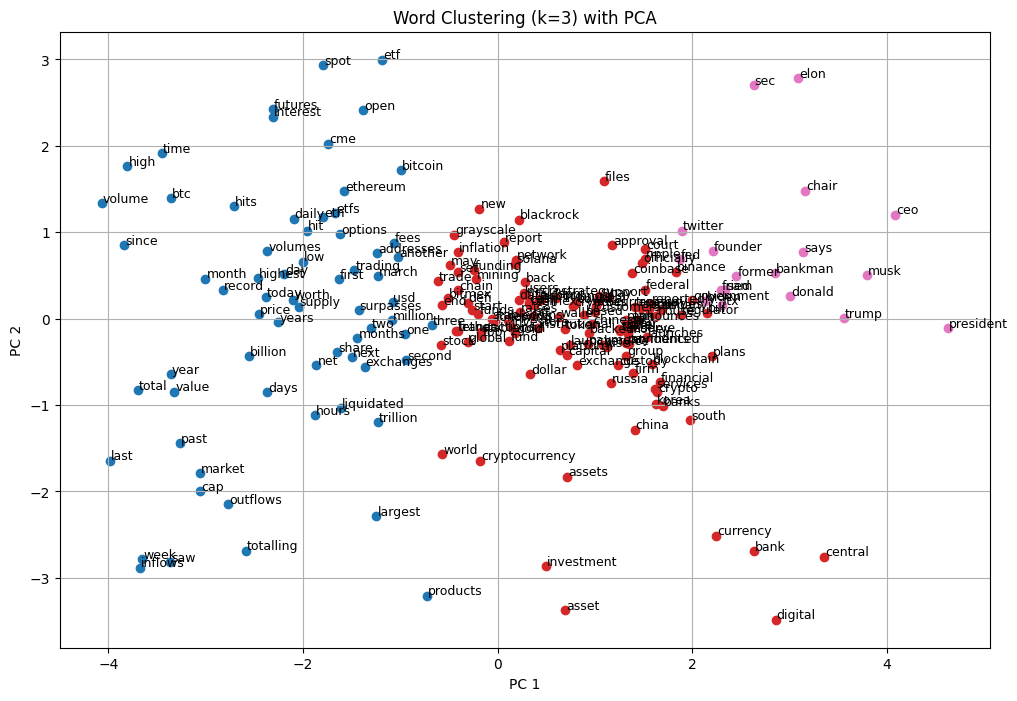

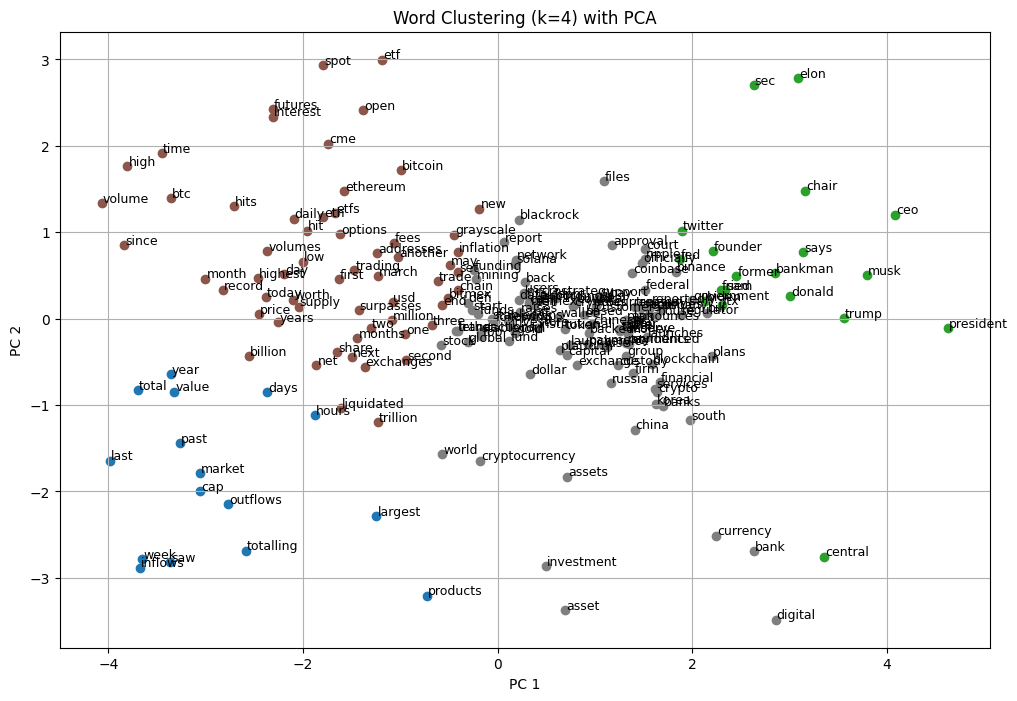

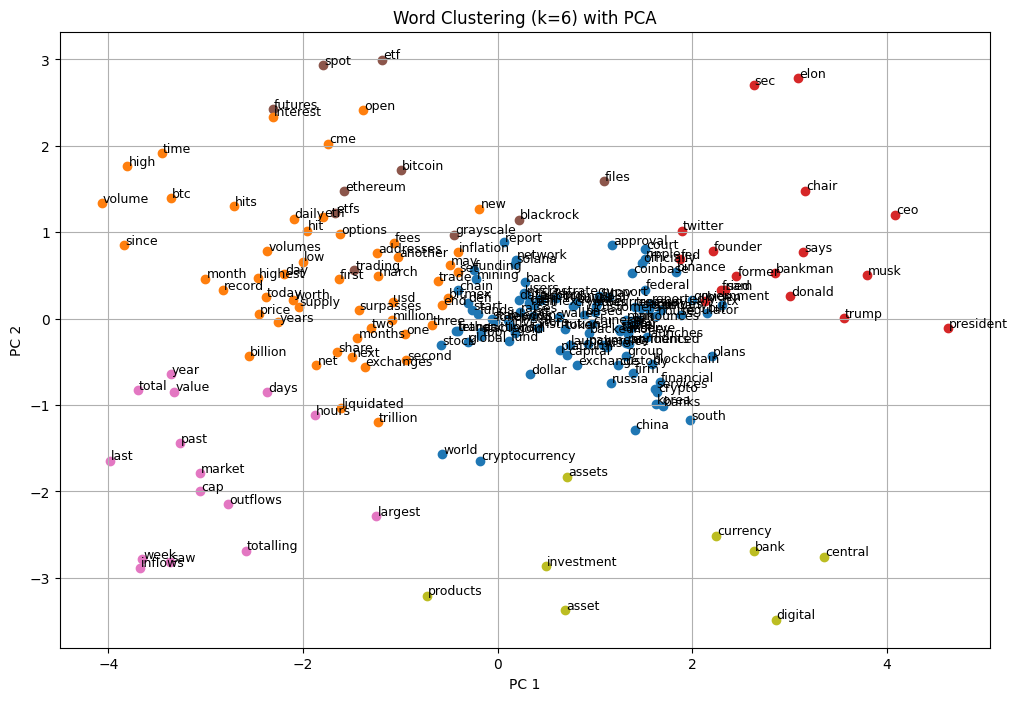

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

X = vectors  # make sure it's a NumPy array
words = top_words  # must be the same length as X

silhouette_scores = []
cluster_range = range(2, 10)
all_labels = []
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
    labels = kmeans.labels_
    all_labels.append(labels)

    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Optional: Silhouette score plot
# plt.figure(figsize=(10, 4))
# plt.plot(cluster_range, silhouette_scores, marker='o')
# plt.title('Silhouette Score for Different k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.grid(True)
# plt.show()

def plot_a(k_index):
    best_k = cluster_range[k_index]
    best_labels = all_labels[k_index]

    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(best_labels.astype(float) / best_k)

    for i, word in enumerate(words):
        x, y = X_2d[i]
        plt.scatter(x, y, color=colors[i])
        plt.text(x + 0.01, y + 0.01, word, fontsize=9)

    plt.title(f'Word Clustering (k={best_k}) with PCA')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.grid(True)
    plt.show()

plot_a(0)
plot_a(1)
plot_a(2)
plot_a(4)
